In [1]:
# Date: 22-5-2017

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# note:
# Because of the 十一黃金周. sth is strange with (2,0,'tot') and others vol from 1 Oct 00:00 to 7 Oct 23:59

df_merged_volume = pd.read_csv("../data/preprocessed_input_interpolate_20min.csv")

In [3]:
# change "Date" to datetime object
df_merged_volume['date'] = pd.to_datetime(df_merged_volume['date'])

# construct "time of day"
df_merged_volume['timeofday'] = df_merged_volume.date.apply( lambda d : d.hour+d.minute/60.)

In [4]:
df_merged_volume.head(10)

,"(1, 0, 'cargocar')","(1, 0, 'etc')","(1, 0, 'motorcycle')","(1, 0, 'privatecar')","(1, 0, 'tot')","(1, 0, 'unknowncar')","(1, 1, 'cargocar')","(1, 1, 'etc')","(1, 1, 'motorcycle')","(1, 1, 'privatecar')",...,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,dayofweek,is_holiday,timeofday
0,0,1.0,0,0,14.0,14.0,38.0,25.0,89.0,12.0,...,1013.200000,1018.200000,341.000000,3.5,21.100000,68.000000,0.0,1,0,0.000000
1,0,0.0,0,0,13.0,13.0,24.0,11.0,41.0,15.0,...,1013.233333,1018.233333,342.444444,3.4,21.411111,66.888889,0.0,1,0,0.333333
2,0,1.0,0,0,7.0,7.0,10.0,7.0,22.0,5.0,...,1013.266667,1018.266667,343.888889,3.3,21.722222,65.777778,0.0,1,0,0.666667
3,0,2.0,0,0,6.0,6.0,3.0,0.0,3.0,0.0,...,1013.300000,1018.300000,345.333333,3.2,22.033333,64.666667,0.0,1,0,1.000000
4,0,1.0,0,0,5.0,5.0,5.0,0.0,3.0,0.0,...,1013.333333,1018.333333,346.777778,3.1,22.344444,63.555556,0.0,1,0,1.333333
5,0,1.0,0,0,5.0,5.0,3.0,1.0,8.0,0.0,...,1013.366667,1018.366667,348.222222,3.0,22.655556,62.444444,0.0,1,0,1.666667
6,0,0.0,0,0,6.0,6.0,6.0,1.0,2.0,0.0,...,1013.400000,1018.400000,349.666667,2.9,22.966667,61.333333,0.0,1,0,2.000000
7,0,2.0,0,0,9.0,9.0,8.0,1.0,4.0,0.0,...,1013.433333,1018.433333,351.111111,2.8,23.277778,60.222222,0.0,1,0,2.333333
8,0,0.0,0,0,7.0,7.0,4.0,1.0,4.0,0.0,...,1013.466667,1018.466667,352.555556,2.7,23.588889,59.111111,0.0,1,0,2.666667
9,0,0.0,0,0,10.0,10.0,2.0,0.0,0.0,0.0,...,1013.500000,1018.500000,354.000000,2.6,23.900000,58.000000,0.0,1,0,3.000000


In [5]:
# Check all the columns

for idx, i in enumerate(df_merged_volume.columns):
    print(idx, i)

0 (1, 0, 'cargocar')
1 (1, 0, 'etc')
2 (1, 0, 'motorcycle')
3 (1, 0, 'privatecar')
4 (1, 0, 'tot')
5 (1, 0, 'unknowncar')
6 (1, 1, 'cargocar')
7 (1, 1, 'etc')
8 (1, 1, 'motorcycle')
9 (1, 1, 'privatecar')
10 (1, 1, 'tot')
11 (1, 1, 'unknowncar')
12 (2, 0, 'cargocar')
13 (2, 0, 'etc')
14 (2, 0, 'motorcycle')
15 (2, 0, 'privatecar')
16 (2, 0, 'tot')
17 (2, 0, 'unknowncar')
18 (3, 0, 'cargocar')
19 (3, 0, 'etc')
20 (3, 0, 'motorcycle')
21 (3, 0, 'privatecar')
22 (3, 0, 'tot')
23 (3, 0, 'unknowncar')
24 (3, 1, 'cargocar')
25 (3, 1, 'etc')
26 (3, 1, 'motorcycle')
27 (3, 1, 'privatecar')
28 (3, 1, 'tot')
29 (3, 1, 'unknowncar')
30 ('A', 2)
31 ('A', 3)
32 ('B', 1)
33 ('B', 3)
34 ('C', 1)
35 ('C', 3)
36 date
37 hour
38 pressure
39 sea_pressure
40 wind_direction
41 wind_speed
42 temperature
43 rel_humidity
44 precipitation
45 dayofweek
46 is_holiday
47 timeofday


In [6]:
''' Make the dataset stationary '''

df_merged_volume_copy = df_merged_volume.copy()

for i in range(1, len(df_merged_volume_copy)):
    df_merged_volume_copy.loc[i, df_merged_volume_copy.columns[0:36]] = df_merged_volume.loc[i, df_merged_volume.columns[0:36]] - df_merged_volume.loc[i-1, df_merged_volume.columns[0:36]]

In [7]:
# Check Stationary dataframe

df_merged_volume_copy

,"(1, 0, 'cargocar')","(1, 0, 'etc')","(1, 0, 'motorcycle')","(1, 0, 'privatecar')","(1, 0, 'tot')","(1, 0, 'unknowncar')","(1, 1, 'cargocar')","(1, 1, 'etc')","(1, 1, 'motorcycle')","(1, 1, 'privatecar')",...,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,dayofweek,is_holiday,timeofday
0,0,1.0,0,0,14.0,14.0,38.0,25.0,89.0,12.0,...,1013.200000,1018.200000,341.000000,3.500000,21.100000,68.000000,0.0,1,0,0.000000
1,0,-1.0,0,0,-1.0,-1.0,-14.0,-14.0,-48.0,3.0,...,1013.233333,1018.233333,342.444444,3.400000,21.411111,66.888889,0.0,1,0,0.333333
2,0,1.0,0,0,-6.0,-6.0,-14.0,-4.0,-19.0,-10.0,...,1013.266667,1018.266667,343.888889,3.300000,21.722222,65.777778,0.0,1,0,0.666667
3,0,1.0,0,0,-1.0,-1.0,-7.0,-7.0,-19.0,-5.0,...,1013.300000,1018.300000,345.333333,3.200000,22.033333,64.666667,0.0,1,0,1.000000
4,0,-1.0,0,0,-1.0,-1.0,2.0,0.0,0.0,0.0,...,1013.333333,1018.333333,346.777778,3.100000,22.344444,63.555556,0.0,1,0,1.333333
5,0,0.0,0,0,0.0,0.0,-2.0,1.0,5.0,0.0,...,1013.366667,1018.366667,348.222222,3.000000,22.655556,62.444444,0.0,1,0,1.666667
6,0,-1.0,0,0,1.0,1.0,3.0,0.0,-6.0,0.0,...,1013.400000,1018.400000,349.666667,2.900000,22.966667,61.333333,0.0,1,0,2.000000
7,0,2.0,0,0,3.0,3.0,2.0,0.0,2.0,0.0,...,1013.433333,1018.433333,351.111111,2.800000,23.277778,60.222222,0.0,1,0,2.333333
8,0,-2.0,0,0,-2.0,-2.0,-4.0,0.0,0.0,0.0,...,1013.466667,1018.466667,352.555556,2.700000,23.588889,59.111111,0.0,1,0,2.666667
9,0,0.0,0,0,3.0,3.0,-2.0,-1.0,-4.0,0.0,...,1013.500000,1018.500000,354.000000,2.600000,23.900000,58.000000,0.0,1,0,3.000000


In [8]:
# select the time for training: 6:20-10:00 (5 + 6 timestamp) and 15:20-19:00 (5 + 6 timestamp)

sel_rows = df_merged_volume_copy[ ((df_merged_volume_copy.timeofday>= 6.3) & (df_merged_volume_copy.timeofday<10)) |
                            ((df_merged_volume_copy.timeofday>=15.3) & (df_merged_volume_copy.timeofday<19))]

In [9]:
# select using columns

using_cols = [
#                 "(1, 0, 'cargocar')",
#                 "(1, 0, 'etc')",
#                 "(1, 0, 'motorcycle')",
#                 "(1, 0, 'privatecar')",
#                 "(1, 0, 'tot')",
#                 "(1, 0, 'unknowncar')",
#                 "(1, 1, 'cargocar')",
#                 "(1, 1, 'etc')",
#                 "(1, 1, 'motorcycle')",
#                 "(1, 1, 'privatecar')",
#                 "(1, 1, 'tot')",
#                 "(1, 1, 'unknowncar')",
#                 "(2, 0, 'cargocar')",
                "(2, 0, 'etc')",
#                 "(2, 0, 'motorcycle')",
#                 "(2, 0, 'privatecar')",
                "(2, 0, 'tot')",
#                 "(2, 0, 'unknowncar')",
#                 "(3, 0, 'cargocar')",
#                 "(3, 0, 'etc')",
#                 "(3, 0, 'motorcycle')",
#                 "(3, 0, 'privatecar')",
#                 "(3, 0, 'tot')",
#                 "(3, 0, 'unknowncar')",
#                 "(3, 1, 'cargocar')",
#                 "(3, 1, 'etc')",
#                 "(3, 1, 'motorcycle')",
#                 "(3, 1, 'privatecar')",
#                 "(3, 1, 'tot')",
#                 "(3, 1, 'unknowncar')",
                "('A', 2)",
#                 "('A', 3)",
#                 "('B', 1)",
#                 "('B', 3)",
#                 "('C', 1)",
#                 "('C', 3)",
                'date',
                'hour',
                'pressure',
                'sea_pressure',
                'wind_direction',
                'wind_speed',
                'temperature',
                'rel_humidity',
                'precipitation',
                'dayofweek',
                'is_holiday',
                'timeofday'
              ]

sel_rows = sel_rows[using_cols]

In [18]:
# split to train and valid set
train_rows = sel_rows[: -22*7]
valid_rows = sel_rows[-22*7:] # reserve 7 days for test

# del date column for eliminate datetime
del train_rows['date']
del valid_rows['date']

# get numpy array from panda dataframe
train_arr = train_rows.values
valid_arr = valid_rows.values

# np.shape(train_arr)
# Out:
# (726, 17)

In [19]:
#scale feature array to range -1 to 1

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_arr)
train_scaled_arr = scaler.transform(train_arr)

valid_scaled_arr = scaler.transform(valid_arr)

In [20]:
# sample subsequence from the time series
train_seqs = []
nSegments = len(train_scaled_arr)//11 # each segment holds 4hr data (12 datapoints, 20min each)
for segment in range(nSegments):
    for t in range(6):
        startIdx = segment*11 + t
        train_seqs.append(train_scaled_arr[startIdx: startIdx+6])  # append 6 timestamps each time (5 timestamps for x, 1 timestamp for y)
train_seqs = np.stack(train_seqs)

valid_seqs = []
nSegments = len(valid_scaled_arr)//11 # each segment holds 4hr data (12 datapoints, 20min each)
for segment in range(nSegments):
    for t in range(6):
        startIdx = segment*11 + t
        valid_seqs.append(valid_scaled_arr[startIdx: startIdx+6])
valid_seqs = np.stack(valid_seqs)

In [13]:
train_seqs[:,:,0:6].shape  # checking for Index 0 to index 5 (6 values) for output

(312, 6, 6)

In [21]:
#keras
#https://keras.io/getting-started/sequential-model-guide/#examples
input_dim = len(using_cols) - 1  # The minus 1 is for deleted "date" feature
output_dim = 3  # 2 vloumns and 1 traffic time output only
timesteps = 5 # use 5 timesteps to predict the 6th

x_train, y_train = train_seqs[:, 0:-1], train_seqs[:, -1,0:3]  # 0:3 is for output dimensions
x_valid , y_valid  =  valid_seqs[:, 0:-1],  valid_seqs[:, -1,0:3]

In [15]:
y_train.shape

(312, 3)

In [22]:
num_epochs = 200
loss_fuc = 'mean_squared_error'

# construct the callback
filepath="for_checking_only.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model = Sequential()
model.add(LSTM(128, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(LSTM(128))
model.add(Dense(output_dim))
model.compile(loss=loss_fuc, optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 128)            73216     
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 205,187
Trainable params: 205,187
Non-trainable params: 0
_________________________________________________________________
Train on 252 samples, validate on 84 samples
Epoch 1/200
252/252 [==============================] - 2s - loss: 0.0503 - val_loss: 0.0450
Epoch 2/200
252/252 [==============================] - 0s - loss: 0.0409 - val_loss: 0.0471
Epoch 3/200
252/252 [==============================] - 0s - loss: 0.0388 - val_loss: 0.0449
Epoch 4/200
252/252 [==============================] - 0s - loss: 0.0384 - val_

252/252 [==============================] - 0s - loss: 0.0338 - val_loss: 0.0435
Epoch 36/200
252/252 [==============================] - 0s - loss: 0.0334 - val_loss: 0.0444
Epoch 37/200
252/252 [==============================] - 0s - loss: 0.0334 - val_loss: 0.0433
Epoch 38/200
252/252 [==============================] - 0s - loss: 0.0332 - val_loss: 0.0424
Epoch 39/200
252/252 [==============================] - 0s - loss: 0.0330 - val_loss: 0.0432
Epoch 40/200
252/252 [==============================] - 0s - loss: 0.0335 - val_loss: 0.0434
Epoch 41/200
252/252 [==============================] - 0s - loss: 0.0326 - val_loss: 0.0432
Epoch 42/200
252/252 [==============================] - 0s - loss: 0.0327 - val_loss: 0.0432
Epoch 43/200
252/252 [==============================] - 0s - loss: 0.0321 - val_loss: 0.0442
Epoch 44/200
252/252 [==============================] - 0s - loss: 0.0321 - val_loss: 0.0444
Epoch 45/200
252/252 [==============================] - 0s - loss: 0.0318 - val_los

252/252 [==============================] - 0s - loss: 0.0199 - val_loss: 0.0558
Epoch 78/200
252/252 [==============================] - 0s - loss: 0.0202 - val_loss: 0.0554
Epoch 79/200
252/252 [==============================] - 0s - loss: 0.0192 - val_loss: 0.0578
Epoch 80/200
252/252 [==============================] - 0s - loss: 0.0195 - val_loss: 0.0589
Epoch 81/200
252/252 [==============================] - 0s - loss: 0.0192 - val_loss: 0.0554
Epoch 82/200
252/252 [==============================] - 0s - loss: 0.0193 - val_loss: 0.0629
Epoch 83/200
252/252 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0572
Epoch 84/200
252/252 [==============================] - 0s - loss: 0.0178 - val_loss: 0.0550
Epoch 85/200
252/252 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0615
Epoch 86/200
252/252 [==============================] - 0s - loss: 0.0174 - val_loss: 0.0603
Epoch 87/200
252/252 [==============================] - 0s - loss: 0.0179 - val_los

252/252 [==============================] - 0s - loss: 0.0113 - val_loss: 0.0820
Epoch 119/200
252/252 [==============================] - 0s - loss: 0.0114 - val_loss: 0.0812
Epoch 120/200
252/252 [==============================] - 0s - loss: 0.0112 - val_loss: 0.0822
Epoch 121/200
252/252 [==============================] - 0s - loss: 0.0110 - val_loss: 0.0809
Epoch 122/200
252/252 [==============================] - 0s - loss: 0.0109 - val_loss: 0.0814
Epoch 123/200
252/252 [==============================] - 0s - loss: 0.0108 - val_loss: 0.0814
Epoch 124/200
252/252 [==============================] - 0s - loss: 0.0114 - val_loss: 0.0826
Epoch 125/200
252/252 [==============================] - 0s - loss: 0.0118 - val_loss: 0.0842
Epoch 126/200
252/252 [==============================] - 0s - loss: 0.0123 - val_loss: 0.0818
Epoch 127/200
252/252 [==============================] - 0s - loss: 0.0113 - val_loss: 0.0836
Epoch 128/200
252/252 [==============================] - 0s - loss: 0.0114

252/252 [==============================] - 0s - loss: 0.0076 - val_loss: 0.0950
Epoch 161/200
252/252 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0941
Epoch 162/200
252/252 [==============================] - 0s - loss: 0.0075 - val_loss: 0.0958
Epoch 163/200
252/252 [==============================] - 0s - loss: 0.0070 - val_loss: 0.0927
Epoch 164/200
252/252 [==============================] - 0s - loss: 0.0073 - val_loss: 0.0936
Epoch 165/200
252/252 [==============================] - 0s - loss: 0.0071 - val_loss: 0.0944
Epoch 166/200
252/252 [==============================] - 0s - loss: 0.0067 - val_loss: 0.0919
Epoch 167/200
252/252 [==============================] - 0s - loss: 0.0069 - val_loss: 0.0957
Epoch 168/200
252/252 [==============================] - 0s - loss: 0.0069 - val_loss: 0.0952
Epoch 169/200
252/252 [==============================] - 0s - loss: 0.0069 - val_loss: 0.0956
Epoch 170/200
252/252 [==============================] - 0s - loss: 0.0065

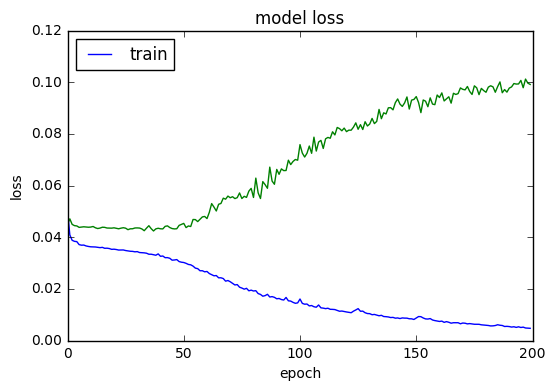

In [23]:
## Start Training
model.summary()
history_w_model = model.fit(x_train, y_train, callbacks=callbacks_list, epochs=num_epochs, batch_size=64, validation_data=(x_valid, y_valid))

plt.plot(history_w_model.history['loss'], label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.plot(history_w_model.history['val_loss'], label='Val_loss')
plt.show()

In [24]:
# load weights into the model
model.load_weights("for_checking_only.hdf5")
print("Loaded model from disk")

model.compile(loss='mean_squared_error', optimizer='adam')

Loaded model from disk


In [322]:
''' === Prediction ===
Procedure:
1. Load CSV
2. to_datetime
3. create timeofday column
4. select the time for training: 6:00-8:00 (6 timestamps) and 15:00-17:00 (6 timestamps)
5. change it to stationary
6. Use using_cols to select the features
7. del 'date'
8. change to np array
9. MinMaxScaler
10. make the sequences tensor as input
11. make a forloop for prediction

'''
# 1. Load CSV - Vol + Route + Weather (Only Weather is 24-hour data)
df_pred = pd.read_csv('../data/')

# 2. to_datetime
df_pred['date'] = pd.to_datetime(df_pred['date'])

# 3. create timeofday column
df_pred['timeofday'] = df_pred.date.apply( lambda d : d.hour+d.minute/60.)

# 4. select the time for training

df_pred_sel_time = df_pred[ ((df_merged_volume_copy.timeofday>= 6) & (df_merged_volume_copy.timeofday<8)) |
                            ((df_merged_volume_copy.timeofday>=15) & (df_merged_volume_copy.timeofday<17))]

df_feedin_weather_sel_time = df_pred[ ((df_merged_volume_copy.timeofday>= 8) & (df_merged_volume_copy.timeofday<10)) |
                            ((df_merged_volume_copy.timeofday>=17) & (df_merged_volume_copy.timeofday<19))]

# 5. change it to stationary
df_pred_sel_time = df_pred_sel_time.reset_index(drop=True)

df_pred_sel_time_copy = df_pred_sel_time.copy()



for i in range(len(df_pred_sel_time_copy)//6):  # make the loop for 14 time slots (2 different time slot x 7days)
    for t in range(5):  #  Do the "difference" 5 times every loop
        start_idx = i*6 + t + 1  # Add 1 is for starting it from index 1 in every 6-space time slot
        df_pred_sel_time_copy.loc[start_idx, df_pred_sel_time_copy.columns[0:36]] = df_pred_sel_time.loc[start_idx, df_pred_sel_time.columns[0:36]] - df_pred_sel_time.loc[start_idx-1, df_pred_sel_time.columns[0:36]]

# 6. Use using_cols to select the features
sel_rows_pred = df_pred_sel_time_copy[ using_cols ]

sel_rows_feedin_weather = df_feedin_weather_sel_time[using_cols[3:]]

# 7. del 'date'
del sel_rows_pred['date']
del sel_rows_feedin_weather['date']

# 8. change to np array
pred_arr = sel_rows_pred.values

feedin_weather_arr = sel_rows_feedin_weather.values

# 9. MinMaxScaler
pred_arr_scaled = scaler.transform(pred_arr)

# add some dummy cells in front of the weather_array for transform
temp_arr = np.zeros((84,3))
feedin_weather_arr = np.concatenate([temp_arr, feedin_weather_arr], axis=1)

feedin_weather_arr_scaled = scaler.transform(feedin_weather_arr)

# Now pred_arr_scaled is (84 x 17)

/Users/Kin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/Kin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [323]:
# 10. make the sequences tensor as input
# Put into the model to get the prediction

ans_arr = []  # For holding the output answer
    
for i in range(len(pred_arr_scaled)//6):  # make the loop for 14 time slots (2 different time slot x 7days)
    # creating pre_seq
    pred_seq = []
    for t in range(5):  #  Do the "difference" 5 times every loop
        k = i*6 + t + 1  # Add 1 is for starting it from index 1 in every 6-space time slot, to ignore the first index which is non-stationary
        pred_seq.append(pred_arr_scaled[k])  # creating a sequence for a time slot
    
    # creating feedin_weather_seq
    feedin_weather_seq = []
    for t in range(6):  #  Do 6 times every loop
        k = i*6 + t  #
        feedin_weather_seq.append(feedin_weather_arr_scaled[k])


    pred_seq = np.stack(pred_seq)  # change back to the numpy array (2D)
    pred_seq = pred_seq.reshape(1, pred_seq.shape[0], pred_seq.shape[1])  # change to numpy 3D as input

    feedin_weather_seq = np.stack(feedin_weather_seq)  # change back to the numpy array (2D)
    feedin_weather_seq = feedin_weather_seq.reshape(1, feedin_weather_seq.shape[0], feedin_weather_seq.shape[1])  # change to numpy 3D as input

    for q in range(6):
        # predict next timestamp
        output_pred = model.predict(pred_seq)  # get one prediction output (size (1 x 3))
        ans_arr.append(output_pred)

        # update the input seq
        for j in range(1,5):
            pred_seq[0][j-1] = pred_seq[0][j]
        pred_seq[0][4] = feedin_weather_seq[0][q]
        pred_seq[0][4][0:3] = output_pred[0]

In [314]:
# 11. Backward to the non-stationary, correct scale output

#  Helper functions

def backward_scaler(nn_output):
    tmp = np.zeros(14)
    tmp[0:3] = nn_output
    tmp = scaler.inverse_transform(tmp)
    return tmp[0:3]

def decode(last_timestamp_values, nn_output):
    tmp = np.zeros(14)
    tmp[0:3] = nn_output
    tmp = scaler.inverse_transform(tmp)
    return last_timestamp_values + tmp[0:3]

# create the non-stationary 6:40 and 16:40 for decoding
df_non_station_sel_time = df_pred[ ((df_merged_volume_copy.timeofday>= 7.5) & (df_merged_volume_copy.timeofday<8)) |
                            ((df_merged_volume_copy.timeofday>=16.5) & (df_merged_volume_copy.timeofday<17))]

''' Output the non-stationary Answers (allAns)'''

tmp = df_non_station_sel_time[using_cols[0:3]].values
allAns = []
for i in range(len(tmp)):
    seed = tmp[i]  # non-stationary for reconstructing a sequence
    segmentAns = []
    for timestep in range(6):
        seed = decode(seed, ans_arr[i*6+timestep])
        segmentAns.append(seed)
    allAns.append(segmentAns)

# Change back to np array for easy visualize
allAns = np.array(allAns)


In [329]:
# Checking
for i in allAns:
    print(i)

[[  36.52179618  115.11936277   83.89482761]
 [  37.79215259  102.33503303   84.94230892]
 [  38.05784869  101.9343416    79.10011784]
 [  23.66506636   76.6362073    56.65154649]
 [  16.97176268   58.61350447   45.14071977]
 [  18.44870608   55.48907958   37.17015323]]
[[ 24.45008612  64.95174107  56.3886976 ]
 [ 25.13072504  56.58128543  51.37222254]
 [ 27.04738815  48.22112541  35.40873492]
 [ 28.58971331  39.00137533  26.08068621]
 [ 30.84038023  29.09387629  14.77572424]
 [ 31.81641516  17.43871207   5.51338926]]
[[  39.14359605  111.45953527   87.43406213]
 [  31.96291944  109.65849826   86.55524226]
 [  29.45581917  106.04594712   93.10835795]
 [  32.74891879  111.95764956   93.82222541]
 [  26.9057316   101.91378407   95.29282598]
 [  18.30361511   81.4291492    96.9114671 ]]
[[ 23.17315727  80.6472937   57.24725467]
 [ 23.15143036  76.70620048  69.74401346]
 [ 24.26964075  73.30315528  63.85254783]
 [ 22.37687289  64.6389973   68.39513478]
 [ 23.01884486  61.82683048  67.65033

In [364]:
# 12. Output the CSV file

# create the datetime objects
import datetime

start_8am = datetime.datetime(year=2016, month=10, day=25, hour=8, minute=0, second=0)
start_5pm = datetime.datetime(year=2016, month=10, day=25, hour=17, minute=0, second=0)
add_1_day = datetime.timedelta(days=1)
add_20_min = datetime.timedelta(minutes=20)

'''
allAns[x,y,z]
[x]: Segment (AM & PM, total 14)
[y]: timestamp (6 [20mins])
[z]: 3 features
'''
# allAns[0,:,1]

checkpoint = '2'
direction = '0'
vol_or_traj = 1

with open('{}-{}.csv'.format(checkpoint, direction), 'w') as f:
    for day in range(7):
        for am_pm in range(2):
            if am_pm == 0:
                ref_time = start_8am
            else:
                ref_time = start_5pm
            for timestep in range(6):
                start_timestamp = ref_time + day*add_1_day + timestep*add_20_min
                end_timestamp = start_timestamp + add_20_min
                start_timestr = start_timestamp.strftime("%Y-%m-%d %H:%M:00")
                end_timestr = end_timestamp.strftime("%Y-%m-%d %H:%M:00")
                f.write('{},"[{},{})",{},{}\n'.format(checkpoint,
                                                  start_timestr,
                                                  end_timestr,
                                                  direction,
                                                  allAns[day*2+am_pm, timestep, vol_or_traj ]))




